# Comparison with Expected Improvement

In the following we compare the acquisition function Expected Improvememt (EI) against the Bayes Risk with non-linear quantity of interest $q = \max_{x\in \mathcal{X}} f(x)$.


In [1]:
import torch
from torch import optim
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


from gaussed.distribution import SpectralGP
from gaussed.kernel.matern import MaternKernel

plt.rcParams['figure.figsize'] = [5,5]

## One-Dimensional Case

We consider the optimisation of the following function:

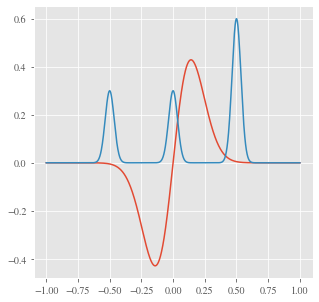

In [33]:
def target1(x):
    return 5 * x * torch.exp(-(5*x)**2)

def target2(x):
    return 0.3 * (torch.exp(- (20 * x)**2) + 2 * torch.exp(- (20 * (x-0.5))**2) +  torch.exp(- (20 * (x+0.5))**2))

X = torch.linspace(-1,1,1000)

plt.plot(X,target1(X))
plt.plot(X,target2(X))

### Define GP

Define a GP with amplitude $\lambda = 1$ and lengthscale parameter $\ell = 0.4$.

In [4]:
k = MaternKernel(2.5,1,parameters=[torch.Tensor([0]), torch.Tensor([0.5])]) #MaternKernel(2.5,1,parameters=[torch.Tensor([0]), torch.Tensor([0.5])])
gp = SpectralGP(k)
gp.set_domain([[-1.05,1.05]])

### Condition on data

In [35]:
X_data = torch.linspace(-1,1,9).unsqueeze(1)  #torch.Tensor([[-1],[-0.1],[0.1],[1]])
Y_data =  target2(X_data).squeeze(1) #target1(X_data).squeeze(1)

phi_mat = gp.basis_matrix(X_data, m=25)

mean, covariance_matrix = gp.condition(phi_mat,Y_data)

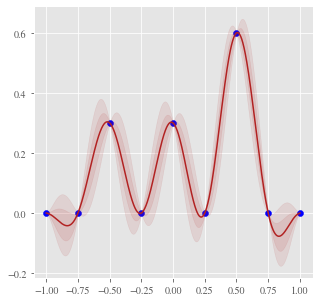

In [36]:
mean_func = gp.get_mean(mean)
var_func = gp.get_variance(covariance_matrix)

m_x = mean_func(X.unsqueeze(1))
v_x = var_func(X.unsqueeze(1)).pow(1/2)

plt.scatter(X_data,Y_data,color="blue")
plt.plot(X,m_x, color = "firebrick", alpha=1)
plt.fill_between(X, m_x - v_x, m_x+v_x, alpha=0.1,color = "firebrick")
plt.fill_between(X, m_x - 2 * v_x, m_x+2*v_x, alpha=0.1,color = "firebrick")
plt.show()

## Plot Acquisition Function

### Expected Improvement

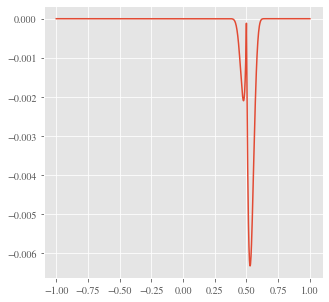

In [37]:
from gaussed.experiment import ExpectedImprovement

expected_improvement = ExpectedImprovement(gp, alpha=0)
plt.plot(X,expected_improvement.eval(X.unsqueeze(1), phi_mat, Y_data, m=25))

### Bayes Risk

In [38]:
from gaussed.experiment import BayesRiskMatheron, L2, EvaluationDesign
from gaussed.solver.optimise_transform import GridSearch
from gaussed.transforms import Maximise
from gaussed.utils.lin_alg_solvers import SafeInverseSolver

n_mesh_max1D = 200
maximise_mesh_1D = torch.linspace(-0.99,0.99, n_mesh_max1D).unsqueeze(1)
maximise_method = GridSearch(maximise_mesh_1D)

q_1D = Maximise(gp, maximise_method)()
loss_1D = L2(q_1D)
design_1D = EvaluationDesign(gp)

bayes_risk = BayesRiskMatheron(q_1D, loss_1D, design_1D)

In [40]:
bayes_risk_eval_list = []

for i in maximise_mesh_1D:
    bayes_risk_eval_list.append(bayes_risk.eval(design_1D.inverse_transform(i), phi_mat, Y_data, m=25, n1=900, n2=30))

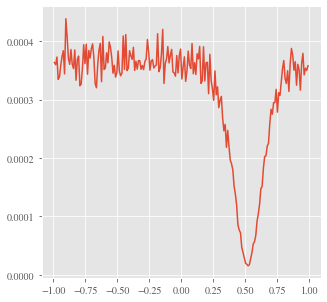

In [41]:
plt.plot(maximise_mesh_1D,torch.stack(bayes_risk_eval_list))

### Plotting output for different designs

The following takes around 60 seconds to run.

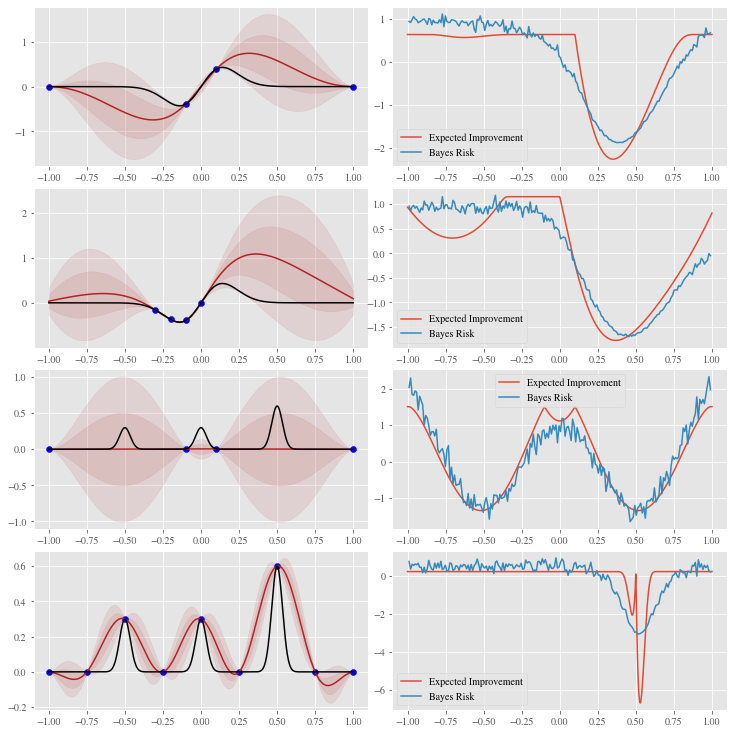

In [54]:
fig = fig, axes = plt.subplots(4, 2, figsize=(10,10)) 

designs = [torch.Tensor([[-1],[-0.1],[0.1],[1]]), torch.Tensor([[0],[-0.1],[-0.2],[-0.3]]), torch.Tensor([[-1],[-0.1],[0.1],[1]]),torch.linspace(-1,1,9).unsqueeze(1)]

targets = [target1, target1, target2, target2]

amplitudes = [torch.Tensor([0]),torch.Tensor([0]),torch.Tensor([0])]
lengthscales =  [torch.Tensor([0.5]),torch.Tensor([0.5]),torch.Tensor([0.5])]

for i in range(4):

    target_i = targets[i]

    X_data = designs[i]
    Y_data = target_i(X_data).flatten()
    phi_mat = gp.basis_matrix(X_data, m=25)
    mean, covariance_matrix = gp.condition(phi_mat,Y_data)

    mean_func = gp.get_mean(mean)
    var_func = gp.get_variance(covariance_matrix)

    m_x = mean_func(X.unsqueeze(1))
    v_x = var_func(X.unsqueeze(1)).pow(1/2)

    axes[i][0].plot(X,m_x, color = "firebrick", alpha=1)
    axes[i][0].plot(X,target_i(X), color="black")
    axes[i][0].fill_between(X, m_x - v_x, m_x+v_x, alpha=0.1,color = "firebrick")
    axes[i][0].fill_between(X, m_x - 2 * v_x, m_x+2*v_x, alpha=0.1,color = "firebrick")
    axes[i][0].scatter(X_data,Y_data,color="blue")

    ei_i = expected_improvement.eval(X.unsqueeze(1), phi_mat, Y_data, m=25)

    bayes_risk_eval_list_i = []
    for j in maximise_mesh_1D:
        bayes_risk_eval_list_i.append(bayes_risk.eval(design_1D.inverse_transform(j), phi_mat, Y_data, m=25, n1=900, n2=30)) # n1=900, n2=30
    br_i = torch.stack(bayes_risk_eval_list_i)

    plot_ei = axes[i][1].plot(X,(ei_i - torch.mean(ei_i)) / torch.var(ei_i).sqrt())
    plot_br = axes[i][1].plot(maximise_mesh_1D,(br_i - torch.mean(br_i)) / torch.var(br_i).sqrt())

    axes[i][1].legend(["Expected Improvement", "Bayes Risk"])

plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.show()



## Designs chosen in 2D

### Define GP

In [57]:
k = MaternKernel(2.5,2,parameters=[torch.Tensor([0]), torch.Tensor([0.2])]) 
gp2D = SpectralGP(k)
gp2D.set_domain([[-1.05,1.05],[-1.05,1.05]])

### Define target and plot

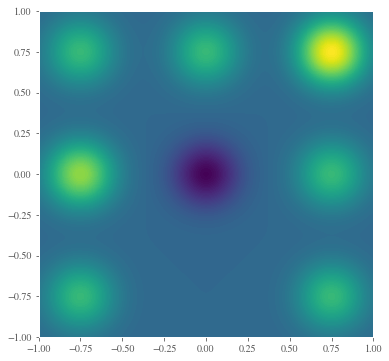

In [91]:
means = torch.Tensor([[0,0],[0.75,0],[0.75,0.75],[0,0.75],[-0.75,0.75],[-0.75,0],[0.75,-0.75],[-0.75,-0.75]])
weights = torch.Tensor([-1,1,2,1,1,1.5,1,1])

def exp_func(x,y):
    SUM = 0
    for i in range(len(means)):
        SUM += weights[i] * torch.exp(- (5 * (x - means[i][0])).pow(2)) * torch.exp(- (5 * (y - means[i][1])).pow(2)) 
    return  SUM

def target(x):
    return exp_func(x.T[0],x.T[1])
    
x = torch.linspace(-1,1,150)
y = torch.linspace(-1,1,150)
X,Y = torch.meshgrid(x,y)

Z = target(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150).T

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=100)
plt.show()

### Expected Improvement SED

In [92]:
from gaussed.experiment import EvaluationDesign
from gaussed.experiment import ExpectedImprovement, Experiment

design = EvaluationDesign(gp2D, initial_design=torch.Tensor([[0,0]]))
expected_improvement2D = ExpectedImprovement(gp2D, design, alpha=0)

def transformed_target(x):
    if x.dim() == 1:
        x = x.unsqueeze(0)
    return target(design.transform(x))

In [98]:
experiment_ei = Experiment(gp2D, transformed_target, design, expected_improvement2D, m=25)
experiment_ei.run(25, optimise_hyper=False)

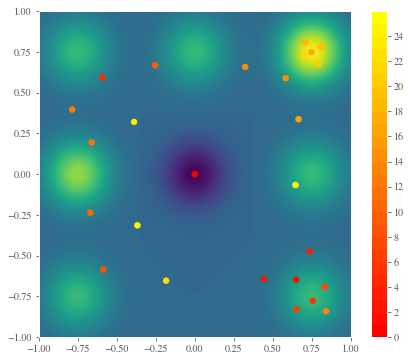

In [99]:
import numpy as np

ei_design = experiment_ei.current_design
max_n = len(ei_design)

fig = plt.figure(figsize=(7,6))

ax = fig.add_subplot(111)
ax.contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=100)
scatter = ax.scatter(design.transform(ei_design).T[0],design.transform(ei_design).T[1],c= torch.cat([torch.Tensor([i]) for i in range(len(design.transform(ei_design)))]), cmap=plt.get_cmap("autumn",max_n), vmin=0, vmax=max_n)
fig.colorbar(scatter, ticks=np.arange(0,max_n,2))
plt.show()

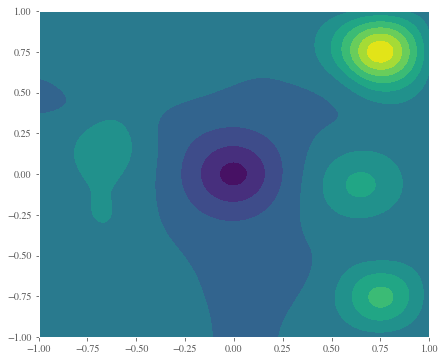

In [100]:
current_design = experiment_ei.current_design
current_data = experiment_ei.data
phi_mat = experiment_ei.design.basis_matrix(current_design, m=25)
mean, covariance_matrix = gp2D.condition(phi_mat, current_data)

mean_function = gp2D.get_mean(mean)

Z1 = mean_function(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150).T

fig = plt.figure(figsize=(7,6))

ax = fig.add_subplot(111)
ax.contourf(X.numpy(), Y.numpy(), Z1.numpy(), levels=10)
plt.show()

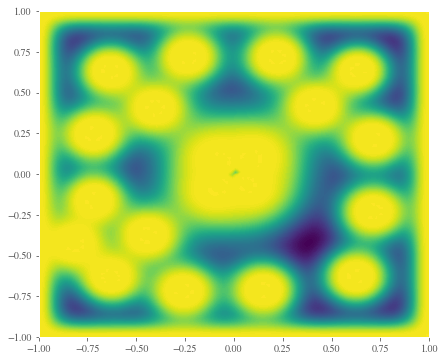

In [70]:
expected_improvement_test = ExpectedImprovement(gp2D, alpha=0)

X,Y = torch.meshgrid(x,y)

Z_ei = expected_improvement_test.eval(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2), experiment_ei.basis_mat, experiment_ei.data, m=25).reshape(150,150).T

fig = plt.figure(figsize=(7,6))

ax = fig.add_subplot(111)
ax.contourf(X.numpy(), Y.numpy(), Z_ei.numpy(), levels=100)
plt.show()

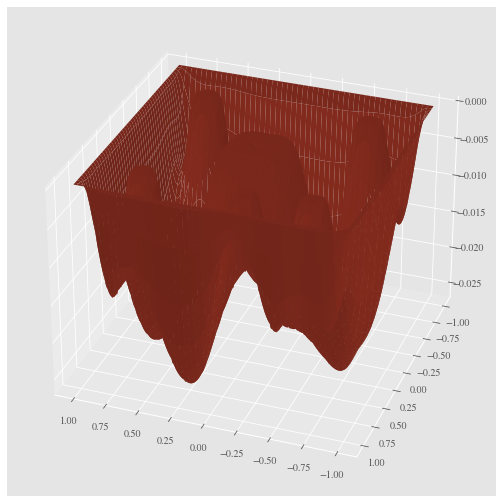

In [64]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30., azim=110)

ax.plot_surface(X.numpy(), Y.numpy(), Z_ei.detach().numpy())
plt.show()

### Bayes Risk

In [95]:
from gaussed.experiment import EvaluationDesign, L2, Experiment
from gaussed.experiment.bayes_risk import BayesRiskMatheron
from gaussed.transforms import Maximise
from gaussed.solver.optimise_transform.grid_search import GridSearch

NN = 40
xxx, yyy = torch.meshgrid(torch.linspace(-1,1,NN),torch.linspace(-1,1,NN))
mesh = torch.stack([xxx,yyy]).T.reshape(NN**2,2)
maximise_method = GridSearch(mesh)

qoi = Maximise(gp2D, maximise_method)()

loss_2D = L2(qoi)
design = EvaluationDesign(gp2D, initial_design=torch.Tensor([[0,0]]))

bayes_risk = BayesRiskMatheron(qoi, loss_2D, design)

experiment_bayes = Experiment(gp2D, transformed_target, design, bayes_risk, m=25)

In [ ]:
experiment_bayes.run(25, optimise_hyper=False)

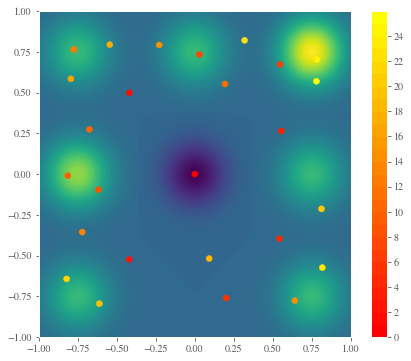

In [97]:
import numpy as np

bayes_design = experiment_bayes.current_design
max_n = len(bayes_design)

fig = plt.figure(figsize=(7,6))

ax = fig.add_subplot(111)
ax.contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=100)
scatter = ax.scatter(design.transform(bayes_design).T[0],design.transform(bayes_design).T[1],c= torch.cat([torch.Tensor([i]) for i in range(len(design.transform(bayes_design)))]), cmap=plt.get_cmap("autumn",max_n), vmin=0, vmax=max_n)
fig.colorbar(scatter, ticks=np.arange(0,max_n,2))
plt.show()

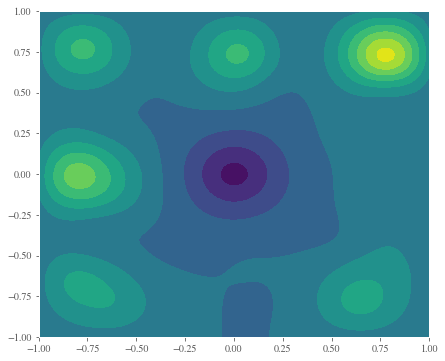

In [101]:
current_design_bayes = experiment_bayes.current_design
current_data_bayes = experiment_bayes.data
phi_mat_bayes = experiment_bayes.design.basis_matrix(current_design_bayes, m=25)
mean_bayes, covariance_matrix_bayes = gp2D.condition(phi_mat_bayes, current_data_bayes)

mean_function_bayes = gp2D.get_mean(mean_bayes)

Z1 = mean_function_bayes(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150).T

fig = plt.figure(figsize=(7,6))

ax = fig.add_subplot(111)
ax.contourf(X.numpy(), Y.numpy(), Z1.numpy(), levels=10)
plt.show()

### Plot output

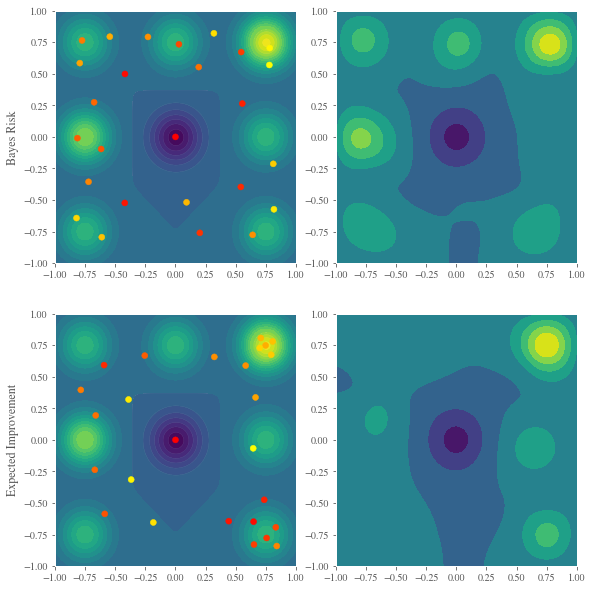

In [124]:
fig = fig, axes = plt.subplots(2,2, figsize=(8,8)) 

axes[0][0].set_ylabel("Bayes Risk")
axes[1][0].set_ylabel("Expected Improvement")

cs1 =  axes[0][0].contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20)
scatter = axes[0][0].scatter(design.transform(bayes_design).T[0],design.transform(bayes_design).T[1],c= torch.cat([torch.Tensor([i]) for i in range(len(design.transform(bayes_design)))]), cmap=plt.get_cmap("autumn",max_n), vmin=0, vmax=max_n)

cs2 =  axes[1][0].contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20)
scatter = axes[1][0].scatter(design.transform(ei_design).T[0],design.transform(ei_design).T[1],c= torch.cat([torch.Tensor([i]) for i in range(len(design.transform(ei_design)))]), cmap=plt.get_cmap("autumn",max_n), vmin=0, vmax=max_n)

cs3 = axes[0][1].contourf(X, Y, mean_function_bayes(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150).T)
cs4 = axes[1][1].contourf(X, Y, mean_function(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150).T)


for c in cs1.collections:
    c.set_edgecolor("face")   

for c in cs2.collections:
    c.set_edgecolor("face")   
plt.tight_layout(pad=0, w_pad=0.2, h_pad=3)
plt.show()